In [1]:
%matplotlib inline
import pdb
import numpy as np
import scipy
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display
from IPython import display
import matplotlib.pyplot
import skimage.color
import skimage.transform

## Low rank textures
Textures and patterns that are man-made often obey certain symmetries and regularities and hence can be approximated by low-rank structure plus some noise. This often true for natural scenes as well. A popular and effective model for this is as follows: 

$$ \boldsymbol Y =  \boldsymbol L + \boldsymbol S $$

Where $\boldsymbol Y$ is the observation, $\boldsymbol L$ is the underlying low-rank structure, and $\boldsymbol S$ is a sparse corruption. Given the observation $\boldsymbol Y$, we would like to recover $\boldsymbol L$ and ignore $\boldsymbol S$ . 

In the following, we will load some simple textures and investigate their dimensionality.

In [2]:
img_list = {0: 'texture_matfiles/circle_texture.mat',
            1: 'texture_matfiles/circsquare_texture.mat',
            2: 'texture_matfiles/hex_texture.mat',
            3: 'texture_matfiles/flower.jpg'}

In [3]:
img_num = 3

if img_num == 3:
    image = plt.imread(img_list[img_num])
    X = skimage.color.rgb2gray(image)
else: 
    image = scipy.io.loadmat(img_list[img_num])
    X = image['J'].astype('float32')
    X = X/255.

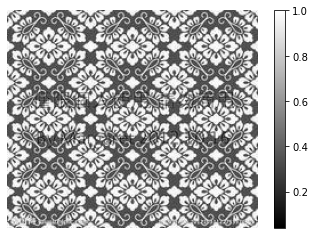

In [4]:
m,n = X.shape

plt.imshow(X, cmap = 'gray'); plt.axis('off'); plt.colorbar()
plt.show()

Although the above texture is a many-pixel array, it has a low effective dimensionality. This can be seen by observing the decay in singular values.

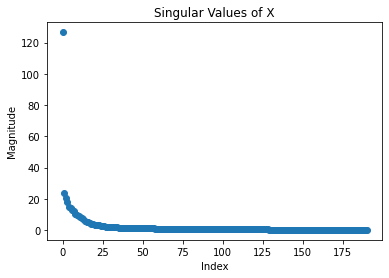

In [5]:
U, s, Vh = scipy.linalg.svd(X)
plt.plot(s,'o')
plt.title('Singular Values of X')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.show()

In [6]:
s.shape

(191,)

For comparison, we plot the pattern associated with the top $r$ singular values.

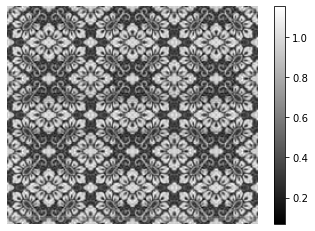

In [7]:
r=12
R = U[:,0:r]@np.diag(s[0:r])@Vh[0:r,:]
plt.imshow(R, cmap = 'gray'); plt.axis('off'); plt.colorbar()
plt.show()

We now do the same for the other textures.

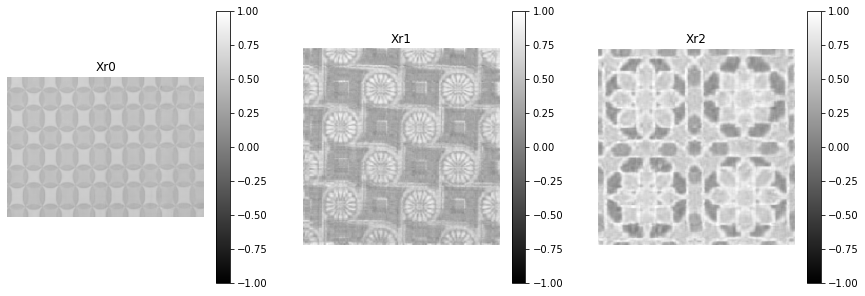

In [8]:
image0 = scipy.io.loadmat(img_list[0])
X0 = image0['J'].astype('float32')
X0 = X0/255.
image1 = scipy.io.loadmat(img_list[1])
X1 = image1['J'].astype('float32')
X1 = X1/255.
image2 = scipy.io.loadmat(img_list[2])
X2 = image2['J'].astype('float32')
X2 = X2/255.

r = 15 ##############
#r=1 uniform gray
#r=2 some texture
#r=3 more texture
#r=5 even more complex patterns emerge
 

U, s, Vh = scipy.linalg.svd(X0)
S0 = np.diag(s[0:r])
Ur0 = U[:,0:r]
Vhr0 = Vh[0:r,:]
Xr0 = Ur0.dot(S0.dot(Vhr0))

U, s, Vh = scipy.linalg.svd(X1)
S1 = np.diag(s[0:r])
Ur1 = U[:,0:r]
Vhr1 = Vh[0:r,:]
Xr1 = Ur1.dot(S1.dot(Vhr1))

U, s, Vh = scipy.linalg.svd(X2)
S2 = np.diag(s[0:r])
Ur2 = U[:,0:r]
Vhr2 = Vh[0:r,:]
Xr2 = Ur2.dot(S2.dot(Vhr2))

plt.figure(figsize = (15,5))
plt.subplot(1,3,1), plt.imshow(Xr0, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Xr0');
plt.subplot(1,3,2), plt.imshow(Xr1, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Xr1');
plt.subplot(1,3,3), plt.imshow(Xr2, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Xr2');


Now to simulate noise, occlusions, or other disturbances, we'll add a sparse corruption, $L$, to the image. 

In [9]:
p = 0.1
mask = np.random.rand(m,n) <= p
Y = X.copy()
Y[mask] = 5*np.random.rand(np.count_nonzero(mask))


# Center image around 0

X = (X-0.5)/0.5
Y = (Y-0.5)/0.5

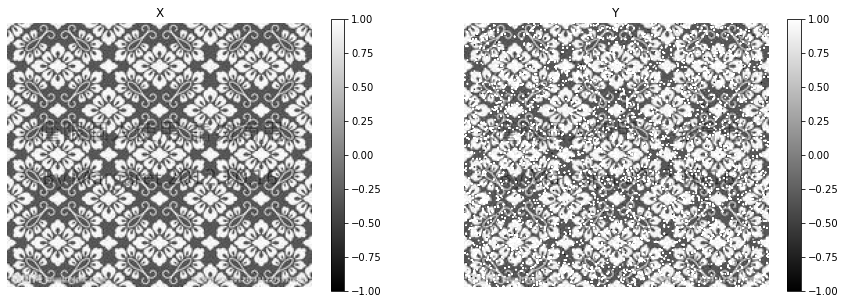

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('X');
plt.subplot(1,2,2), plt.imshow(Y, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Y');

It turns out that the SVD is not robust to these perturbations. As evidenced below, we see that the singular value decay is now much less drastic.

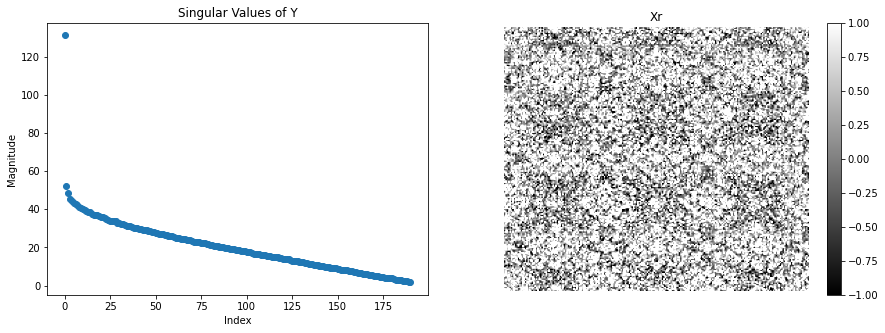

In [11]:
U, s, Vh = scipy.linalg.svd(Y)

r=30
Sr = np.diag(s[0:r])
Ur = U[:,0:r]
Vhr = Vh[0:r,:]
Xr = Ur.dot(Sr.dot(Vhr))

plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.plot(s,'o'), plt.title('Singular Values of Y'), plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.subplot(1,2,2), plt.imshow(Xr, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('Xr');

One way to recover the low rank texture is to solve the low-rank + noise problem using the ADMM algorithm.  The problem can be formulated in the form of Robust PCA (chapter 5 in the main text):

$$ \text{minimize} \quad \|L\|_* + \lambda \|S\|_1 $$
$$ \text{subject to} \qquad \ \  L+S=Y  $$

Here, $Y$ is the observed $m \times n$ image.  We are interested in disentangling the low-rank structure $L$ from the sparse perturbation $S$ given measurements $Y$. 


We can solve this using Principle Component Pursuit by ADMM (Algorithm 5.1 in the main text):

__Input:__ $\boldsymbol S_0 = \boldsymbol \Lambda_0, \mu>0$ <br>
__while__ not converged __do__ <br>
> Compute $\boldsymbol L_{k+1} = D_{1/\mu}(\boldsymbol Y - \boldsymbol S_k + \mu^{-1}\boldsymbol \Lambda_k)$ <br>
Compute $\boldsymbol S_{k+1} = S_{\lambda/\mu}(\boldsymbol Y - \boldsymbol L_{k+1} + \mu^{-1}\boldsymbol \Lambda_k)$ <br>
Compute $\boldsymbol \Lambda_{k+1} = \Lambda_{k} + \mu(\boldsymbol Y - \boldsymbol L_{k+1} - \boldsymbol S_{k+1})$ <br>

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

As stated in the book, the shrinkage operators, $S$ and $D$ have simple and convenient closed form expressions:

$$ S_\tau [x] = \text{sgn}(x)\text{max}(|x| - \tau,0) $$
$$ D_\tau [x] = US_\tau (\Sigma)V^* $$

In [12]:
def shrink(w,t):
    wnew = np.zeros(w.shape)
    for jj in range(w.shape[0]):
        for kk in range(w.shape[1]):
            wnew[jj,kk] = np.sign(w[jj,kk])*np.max([np.abs(w[jj,kk])-t,0])
    return wnew

def svdShrink(x,t):
    U, sval, Vh = scipy.linalg.svd(x)
    sval = np.array([sval])

    r = sval.shape[1]
    Ur = U[:,0:r]
    Vhr = Vh[0:r,:]
    
    Sr = np.diag(shrink(sval,t)[0])
    return Ur.dot(Sr.dot(Vhr))
    

def robust_PCA(Y,lam,mu,tol,maxIter):
    Lam_old = np.zeros(Y.shape)
    S_old = np.zeros(Y.shape)
    isConverged = False
    
    iteration = 0
    while (not isConverged):
        L_new = svdShrink(Y-S_old + 1/mu * Lam_old, 1/mu)
        S_new = shrink(Y-L_new + 1/mu * Lam_old, lam/mu)
        Lam_new = Lam_old + mu * (Y-L_new-S_new)
        #pdb.set_trace()

        if np.linalg.norm(Lam_new-Lam_old)< tol or (iteration > maxIter):
            isConverged = True
        
        S_old = S_new
        Lam_old = Lam_new
        iteration = iteration+1                                                                        
    return L_new, S_new


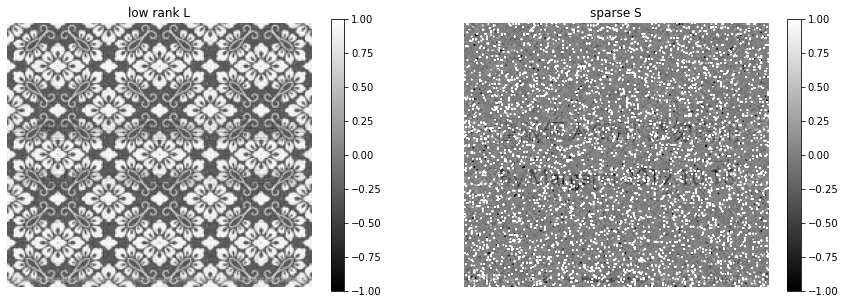

In [13]:
lam = 0.05 #these two parameters seem to require quite a bit of tuning to get things right.
mu = 0.1
maxIter = 20 #we seem to do pretty well with as few as 10 iterations...
tol = 1e-5

L, S = robust_PCA(Y,lam,mu,tol,maxIter)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('low rank L');
plt.subplot(1,2,2), plt.imshow(S, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('sparse S');

# Seems to do significantly better than SVD. Performance could be improved by tuning lam and mu

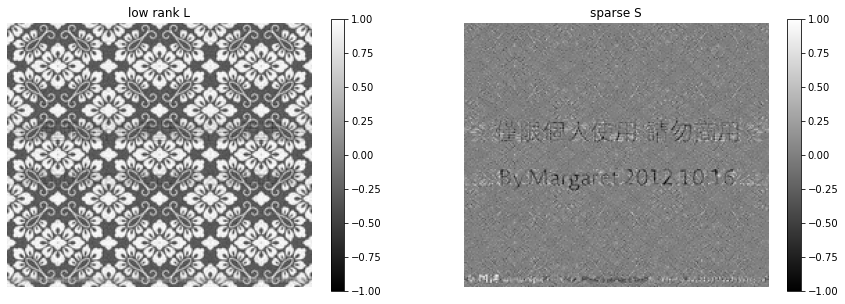

In [14]:
#If we use the RPCA algorithm on the original image without noise, we find the creator of the texture. 
lam = 0.05 
mu = 0.1
maxIter = 20 
tol = 1e-5

L, S = robust_PCA(X,lam,mu,tol,maxIter)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('low rank L');
plt.subplot(1,2,2), plt.imshow(S, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('sparse S');


In our above setup, the parameter $p$ determined the probability a pixel is corrupted in the original image. Above, we had $p=0.1$. As we increase $p$, we should expect the performance of the algorithm to degrade. How graceful is this degredation? 

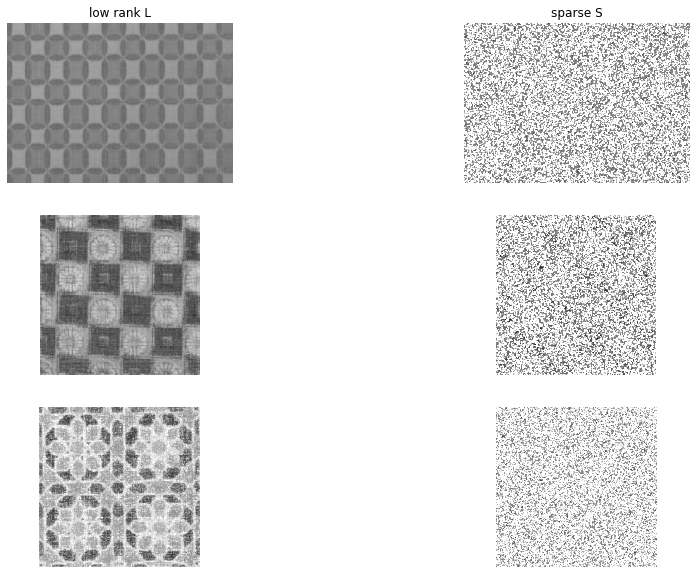

In [15]:
image0 = scipy.io.loadmat(img_list[0])
X0 = image0['J'].astype('float32')
X0 = X0/255.
image1 = scipy.io.loadmat(img_list[1])
X1 = image1['J'].astype('float32')
X1 = X1/255.
image2 = scipy.io.loadmat(img_list[2])
X2 = image2['J'].astype('float32')
X2 = X2/255.

p = 0.35
m,n = X0.shape
mask0 = np.random.rand(m,n) <= p
m,n = X1.shape
mask1 = np.random.rand(m,n) <= p
m,n = X2.shape
mask2 = np.random.rand(m,n) <= p

Y0 = X0.copy()
Y1 = X1.copy()
Y2 = X2.copy()

Y0[mask0] = 5*np.random.rand(np.count_nonzero(mask0))
Y1[mask1] = 5*np.random.rand(np.count_nonzero(mask1))
Y2[mask2] = 5*np.random.rand(np.count_nonzero(mask2))

# Center image around 0
Y0 = (Y0-0.5)/0.5
Y1 = (Y1-0.5)/0.5
Y2 = (Y2-0.5)/0.5

lam = 0.05
mu = 0.1
maxIter = 20
tol = 1e-5

L0, S0 = robust_PCA(Y0,lam,mu,tol,maxIter)
L1, S1 = robust_PCA(Y1,lam,mu,tol,maxIter)
L2, S2 = robust_PCA(Y2,lam,mu,tol,maxIter)

fig, ax = plt.subplots(figsize=(15,10), nrows=3, ncols=2)
ax[0,0].imshow(L0, cmap = 'gray', vmin=-1, vmax=1) 
ax[0,0].axis('off')
ax[0,0].set_title('low rank L');
ax[1,0].imshow(L1, cmap = 'gray', vmin=-1, vmax=1) 
ax[1,0].axis('off')
ax[2,0].imshow(L2, cmap = 'gray', vmin=-1, vmax=1) 
ax[2,0].axis('off')

ax[0,1].imshow(S0, cmap = 'gray', vmin=-1, vmax=1)
ax[0,1].axis('off')
ax[0,1].set_title('sparse S');
ax[1,1].imshow(S1, cmap = 'gray', vmin=-1, vmax=1) 
ax[1,1].axis('off')
ax[2,1].imshow(S2, cmap = 'gray', vmin=-1, vmax=1) 
ax[2,1].axis('off')

plt.show()
#Things begin to fall apart at around p=0.35. The last texture becomes quite garbled. 
#The first and second textures still look rather clean. 
#We could probably improve this result by tuning lam, mu, or the convergence criteria, which
#would come at the expense of a longer runtime.

The above textures are likely to be found in a home decor store. Are natural images really purely low-rank? No. But natural scenes are still highly structured and probably lie on some low-dimensional manifold in the ambient space. Low-rank provides just a linear approximation to this idea.

To investigate this further, we will load a "natural" image -- in this case, a picture the NASA InSight Lander took after 
landing on Mars. The image was found on the NASA website and shows the landing site. We can see the horizon towards the top, 
a "leg" of the lander at the bottom right, and a rock at the bottom. 
The dust particles on the lense are actually on the dust cover and provide an example of a "sparse" disturbance. 
It also appears that the lense nonlinearly distorts the picture because the horizon looks rather curved. 

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1c729a3b4c0>)

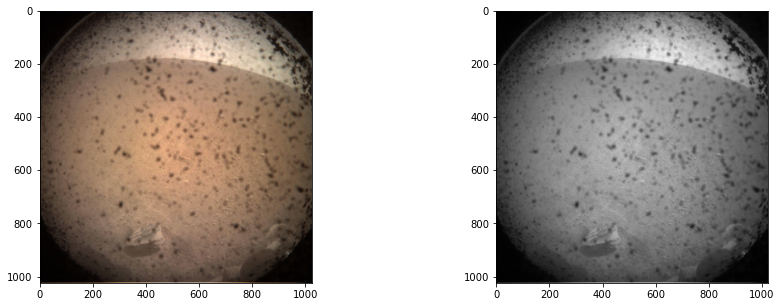

In [16]:
image = matplotlib.pyplot.imread('InSightFirst.png')
X = skimage.color.rgb2gray(image)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(image)
plt.subplot(1,2,2), plt.imshow(X, cmap = 'gray')


In [ ]:
lam = 0.011 # quite a bit of tuning require to get decent results
mu = 0.1
maxIter = 20
tol = 1e-5

L, S = robust_PCA(X,lam,mu,tol,maxIter)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1), plt.imshow(L, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('low rank L');
plt.subplot(1,2,2), plt.imshow(S, cmap = 'gray', vmin=-1, vmax=1); plt.axis('off'), plt.colorbar(); 
plt.title('sparse S');

#I've spent some time trying to tune the parameters, but improved results are perhaps possible.
#The sparse component S captures essentially all of the dust particles. However, it also captures
#some of the finer scale details, such as the horizon, the lens outline, and the texture on the rock and leg.
#The low rank model L recovers the global structure of the image, but loses the above finer scale details.

#It is evident that low-rank behavior is an effective first/linear approximation. 
#More sophisticated methods are required to handle real-world nonlinearities.